- By: Alex Kwon
- Email: alex.kwon [at] hudsonthames [dot] org
- Reference: [Online Portfolio Selection](https://books.google.com/books/about/Online_Portfolio_Selection.html?id=R2fdCgAAQBAJ) by Dr. Bin Li and Dr. Steven Hoi

# Online Portfolio Selection: Exponential Gradient

## Abstract

Momentum strategies have been a popular quantitative strategy in recent decades as the simple but powerful trend following allows investors to exponentially increase their returns.

In this notebook, we will dive into Exponential Gradient, one of the methods for momentum. EG focuses on the best performing asset of the last time period

The package and module behind this implementation of OLPS is currently in the works and will be published on MlFinLab soon.

**1. Exponential Gradient**
    - Multiplicative Update
    - Gradient Projection
    - Expectation Maximization

# Strategy

Throughout the next couple weeks, we will be releasing notebooks on the following strategies

[**Benchmarks**](https://github.com/hudson-and-thames/research/blob/master/Online%20Portfolio%20Selection/Introduction%20to%20Online%20Portfolio%20Selection.ipynb)
- Buy and Hold
- Best Stock
- Constant Rebalanced Portfolio
- Best Constant Rebalanced Portfolio

**Momentum**
- Exponential Gradient
- Follow the Leader
- Follow the Regularized Leader

**Mean Reversion**
- Anti-Correlation
- Passive Aggressive Mean Reversion
- Online Moving Average Reversion
- Robust Median Mean Reversion

**Pattern Matching**
- Nonparametric Histogram/Kernel-Based/Nearest Neighbor Log-Optimal
- Correlation Driven Nonparametric Learning
- Nonparametric Kernel-Based Semi-Log-Optimal/Markowitz/GV

**Meta Algorithm**
- Aggregating Algorithm
- Fast Universalization Algorithm
- Online Gradient Updates
- Online Newton Updates
- Follow the Leading History

**Universal Portfolio**
- Universal Portfolio
- CORN-U
- CORN-K
- SCORN-K
- FCORN-K

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlfinlab.online_portfolio_selection import *

## Import Data

We will use two new datasets for this notebook.
1. MSCI Developed Markets Index from 1993/01/01
    - 23 countries
    - Australia, Austria, Belgium, Canada, Denmark, Finland, France, Germany, Hong Kong, Ireland, Israel, Italy, Japan, Netherlands, New Zealand, Norway, Portugal, Singapore, Spain, Sweden, Switzerland , United Kingdom, USA
    - Dates from 1993/01/01 because Israel was added on that day
    

2. 44 Largest US Companies by Market Capitalization from 2011/01/01
    - http://media.ft.com/cms/253867ca-1a60-11e0-b003-00144feab49a.pdf
    - Exxon Mobil, Apple, Microsoft, Berkshire Hathaway, General Electric, Walmart, Chevron, IBM, PG, ATT, Johnson and Johnson, JP Morgan, Wells Fargo, Oracle, Coca-Cola, Google, Pfizer, Citigroup, Bank of America, Intel, Schlumberger, Cisco, Merck, Philip Morris, PepsiCo, ConocoPhillips, Goldman Sachs, McDonalds, Amazon, Qualcomm, Occidental Petroleum, Abbott Laboratories, Walt Disney, 3M, Comcast, Caterpillar, General Motors, Home Depot, Ford, Freeport-McMoran Copper & Gold, United Parcel Service, Amgen, US Bancorp, American Express
    - Did not include United Technologies, Kraft Food, and Hewlett-Packard due to M&A activities
    
MSCI Developed Market Index data was gathered through Factset Research.

In [2]:
msci = pd.read_csv("MSCI.csv", parse_dates=True, index_col='Date')
msci = msci.dropna()[1:]
msci.head()

,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Hong Kong,Ireland,...,Netherlands,New Zealand,Norway,Portugal,Singapore,Spain,Sweden,Switzerland,United Kingdom,USA
Date,,,,,,,,,,,,,,,,,,,,,
1993-01-01,206.798,802.488,587.954,317.681,708.466,45.425,539.272,516.110,2814.252,116.236,...,669.844,56.582,570.971,50.0644,1493.864,110.685,857.603,747.073,531.980,406.462
1993-01-04,207.161,762.997,578.270,315.775,704.094,45.745,528.307,509.944,2774.171,118.789,...,665.214,56.467,575.934,49.3045,1485.980,109.603,860.098,746.872,529.561,405.946
1993-01-05,204.326,773.126,585.660,315.902,725.571,47.942,534.206,519.754,2840.138,121.627,...,673.522,56.941,598.154,49.4664,1502.087,112.955,876.073,750.217,535.622,404.789
1993-01-06,199.358,777.007,583.992,316.355,736.631,47.764,536.902,517.966,2861.921,124.861,...,674.902,55.390,608.554,49.7653,1505.136,112.732,876.375,747.756,539.342,404.720
1993-01-07,198.023,777.102,582.719,311.936,732.911,49.195,532.265,516.091,2840.306,122.150,...,674.207,55.816,602.541,49.7321,1503.068,112.916,856.715,731.865,537.633,401.040


We will now collect equity data from yfinance.

In [3]:
import yfinance as yf

ticker = ['XOM','AAPL','MSFT','BRK-A','GE','WMT','CVX','IBM','PG','T','JNJ','JPM','WFC','ORCL','KO','Googl','PFE','C','BAC',\
          'INTC','SLB','CSCO','MRK','PM','PEP','COP','GS','MCD','AMZN','QCOM','OXY','ABT','DIS','MMM','CMCSA',\
        'CAT','GM','HD','F','FCX','UPS','AMGN','USB','AXP']

equity = yf.download(ticker)['Adj Close']
equity = equity.loc['2011-01-01':].dropna()
equity.head()

[*********************100%***********************]  44 of 44 completed


,AAPL,ABT,AMGN,AMZN,AXP,BAC,BRK-A,C,CAT,CMCSA,...,PG,PM,QCOM,SLB,T,UPS,USB,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-03,40.868607,17.085857,45.187981,184.220001,37.719135,12.708498,120498.0,44.922279,70.829796,9.417547,...,48.124630,37.988594,38.717251,64.993568,17.702974,55.169281,21.427851,24.231056,43.356121,54.634018
2011-01-04,41.081905,17.246641,46.164131,185.009995,38.197128,12.753277,120200.0,44.922279,70.498779,9.447018,...,48.258369,37.988594,39.326797,63.424110,17.828276,55.048283,21.284679,24.284765,43.522995,54.890518
2011-01-05,41.417946,17.246641,46.147858,187.419998,39.305443,12.986132,121300.0,45.564026,71.108131,9.573311,...,48.146931,37.878529,40.144650,64.169968,17.887941,55.131470,21.332407,24.837217,43.236923,54.743927
2011-01-06,41.384472,17.210915,46.001446,185.860001,39.034901,12.932396,120600.0,45.380680,70.370895,9.581732,...,48.065197,37.373474,40.638466,62.569408,17.645803,54.821392,20.910847,24.668407,42.879337,55.095707
2011-01-07,41.680836,17.282372,46.351238,185.490005,38.712017,12.762233,119681.0,45.289001,70.513832,9.556470,...,47.924019,36.531727,39.913193,63.369705,17.464201,54.564274,20.751772,24.169670,42.974686,55.396179


## Momentum

Momentum strategies are implemented with the belief that the price changes from the previous period will continue.

## 1. Exponential Gradient

Exponential Gradient strategies focus on the following optimization problem that tracks the best performing stock with a learning rate, $\eta$, but also regularizes the new portfolio weight to prevent drastic changes from the previous portfolio.

$b_{t+1} = \underset{b \in \Delta_m}{\arg\max} \: \eta \log b \cdot x_t - R(b,b_t)$

### 1.1 Multiplicative Update 

Helmbold proposed a regularization term that adopts relative entropy.

$R(b,b_t) = \overset{m}{\underset{i=1}{\sum}}b_i \log \frac{b_i}{b_{t,i}}$

    
Using log's first order taylor expansion of $b_i$

$\log b \cdot x_t \approx \log(b_t \cdot x_t) + \frac{x_t}{b_t \cdot x_t}(b-b_t)$

Multiplicative update algorithm can be stated as the following
    
$b_{t+1} = b_t \cdot \exp \left( \eta \frac{x_t}{b_t \cdot x_t} \right)$

If we adopt relative entropy as the regularization factor, we can use log's first order taylor expansion to create an update rule to be the following multiplicative one.

$b_{t+1} = b_t \cdot \exp \left( \eta \frac{x_t}{b_t \cdot x_t} \right) / Z$, where $Z$ is a normalization term to sum the weights to 1

### 1.2 Gradient Projection

Instead of relative entropy, gradient projection adopts an L2-regularization term for the optimization equation.

$R(b,b_t) = \frac{1}{2}\overset{m}{\underset{i=1}{\sum}}(b_i - b_{t,i})^2$

This regularization term can be transcribed to the following update rule

$b_{t+1} = b_t + \eta \cdot \left( \frac{x_t}{b_t \cdot x_t} - \frac{1}{m} \sum_{j=1}^{m} \frac{x_t}{b_t \cdot x_t} \right)$

### 1.3 Expectation Maximization

Expectation Maximization uses a $\chi^2$ regularization term

$R(b-b_t)=\frac{1}{2}\overset{m}{\underset{i=1}{\sum}}\frac{(b_i - b_{t,i})^2}{b_{t,i}}$

Then, the corresponding update rule becomes

$b_{t+1} = b_t \cdot \left( \eta \cdot \left( \frac{x_t}{b_t \cdot x_t} - 1 \right) + 1 \right)$

Each of these update rules can be called using the **ExponentialGradient()** with different update rules with the default being multiplciative updates. Learning rates can also be adjusted by setting **eta**, and if no values are stated default will be 0.05

- Multiplicative Update: ExponentialGradient('MU')
- Gradient Projection: ExponentialGradient('GP')
- Expectation Maximization: ExponentialGradient('EM')

In [6]:
msci_mu_005 = ExponentialGradient(update_rule='MU')
msci_gp_005 = ExponentialGradient(update_rule='GP')
msci_em_005 = ExponentialGradient(update_rule='GP')
msci_mu_005.allocate(msci)
msci_gp_005.allocate(msci)
msci_em_005.allocate(msci)

Progress: |██████████████████████████████████████████████████| 100.0% Complete


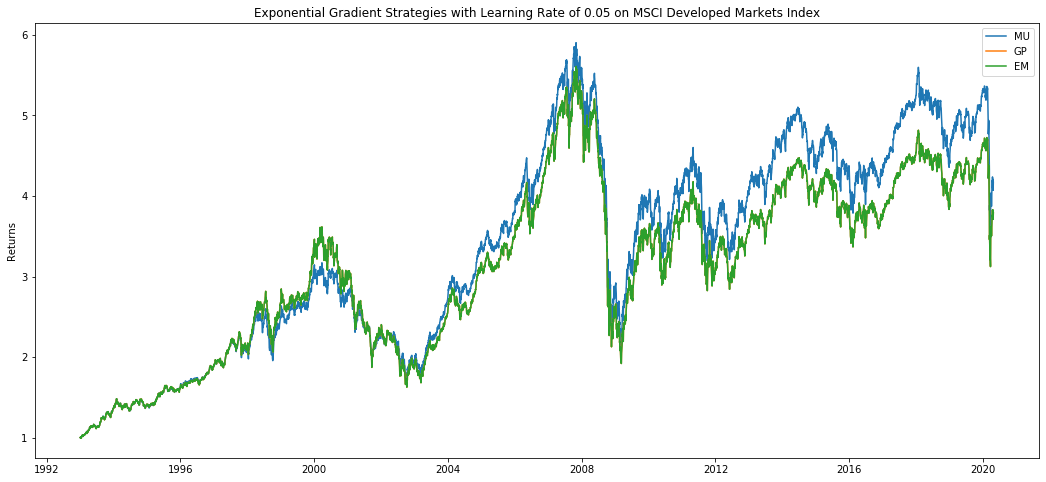

In [8]:
plt.figure(figsize=(18,8));
plt.plot(msci_mu_005.portfolio_return, label = 'MU');
plt.plot(msci_gp_005.portfolio_return, label = 'GP');
plt.plot(msci_em_005.portfolio_return, label = 'EM');
plt.title('Exponential Gradient Strategies with Learning Rate of 0.05 on MSCI Developed Markets Index')
plt.ylabel('Returns')
plt.legend();

Interestingly, the gradient projection method and expectation maximization method return an identical graph, so the orange graph that represents GP cannot be seen.

The returns for the EG strategies are still disappointing, so we will look to increase the learning rate for our EG strategy.

In [11]:
msci_mu_05 = ExponentialGradient(update_rule='MU',eta=0.5)
msci_gp_05 = ExponentialGradient(update_rule='GP',eta=0.5)
msci_em_05 = ExponentialGradient(update_rule='GP',eta=0.5)
msci_mu_05.allocate(msci)
msci_gp_05.allocate(msci)
msci_em_05.allocate(msci)

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete


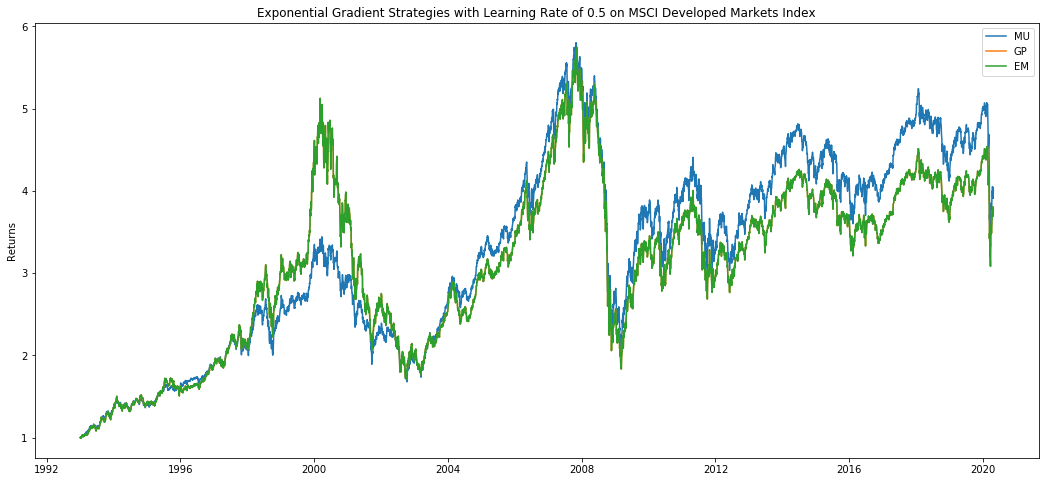

In [12]:
plt.figure(figsize=(18,8));
plt.plot(msci_mu_05.portfolio_return, label = 'MU');
plt.plot(msci_gp_05.portfolio_return, label = 'GP');
plt.plot(msci_em_05.portfolio_return, label = 'EM');
plt.title('Exponential Gradient Strategies with Learning Rate of 0.5 on MSCI Developed Markets Index')
plt.ylabel('Returns')
plt.legend();

From the initial analysis, multiplicative update rules continue to return better returns than the other two methods, and it's difficult to see how learning rate affects the strategy.

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |█████████████████████████████████████████████████-| 98.9% Complete

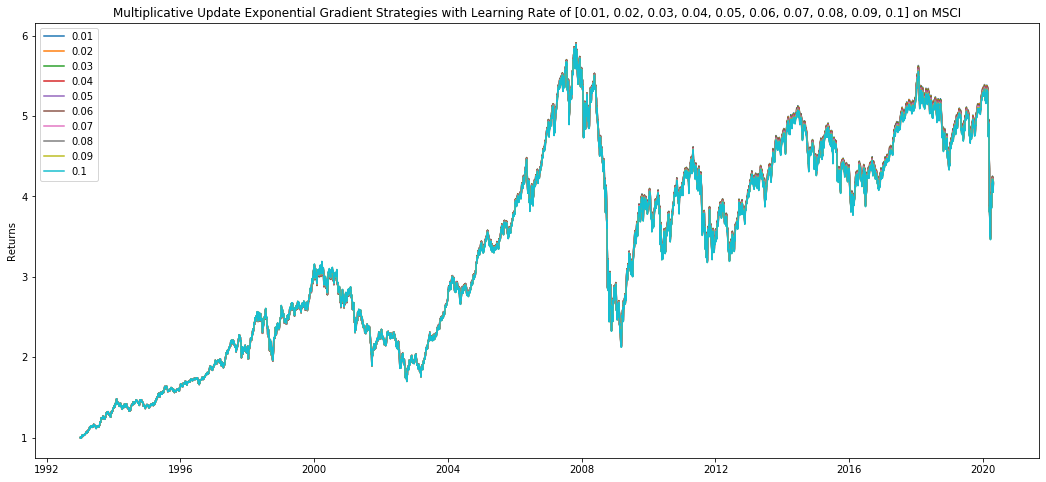

In [14]:
plt.figure(figsize=(18,8));
eta_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
for e in eta_values:
    strat = ExponentialGradient(update_rule='MU',eta=e)
    strat.allocate(msci)
    plt.plot(strat.portfolio_return, label = str(e));
plt.title('Multiplicative Update Exponential Gradient Strategies with Learning Rate of [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1] on MSCI')
plt.ylabel('Returns')
plt.legend();

$\eta$ values of 0.01 to 0.1 seem to provide almost identical returns

Lets try to use a more sparse $\eta$ from 0.1 to 0.9.

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete


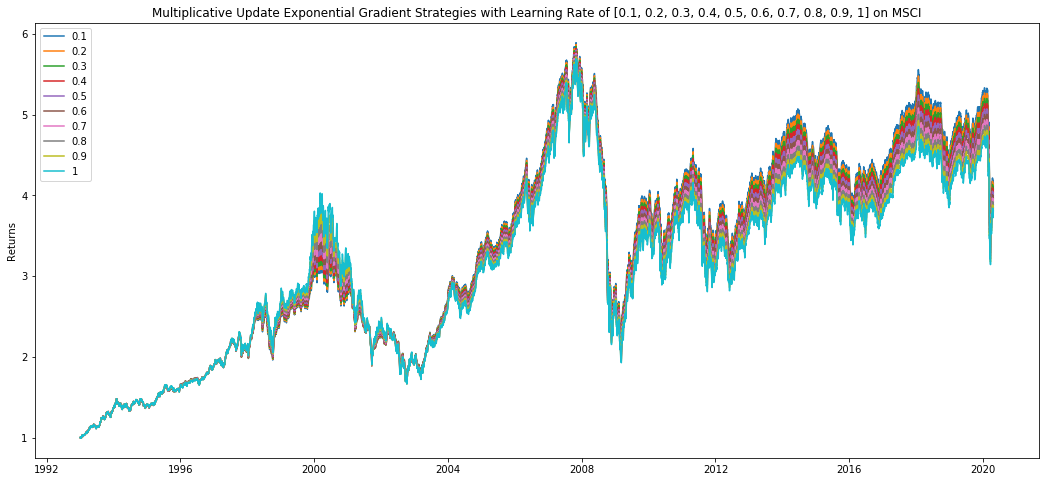

In [15]:
plt.figure(figsize=(18,8));
eta_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
for e in eta_values:
    strat = ExponentialGradient(update_rule='MU',eta=e)
    strat.allocate(msci)
    plt.plot(strat.portfolio_return, label = str(e));
plt.title('Multiplicative Update Exponential Gradient Strategies with Learning Rate of [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1] on MSCI')
plt.ylabel('Returns')
plt.legend();

$\eta$ value for 0.1 to 1 is very similar to the one above. There isn't much difference for the portfolio.

What happens if we move our $\eta$ to a value greater than 1?

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████----| 92.4% Complete

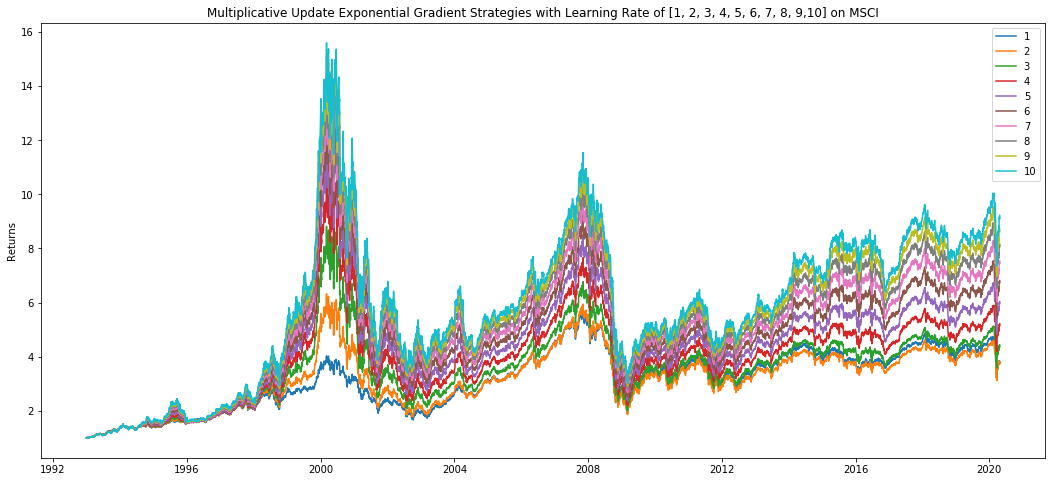

In [16]:
plt.figure(figsize=(18,8));
eta_values = [1, 2, 3, 4, 5, 6, 7, 8, 9,10]
for e in eta_values:
    strat = ExponentialGradient(update_rule='MU',eta=e)
    strat.allocate(msci)
    plt.plot(strat.portfolio_return, label = str(e));
plt.title('Multiplicative Update Exponential Gradient Strategies with Learning Rate of [1, 2, 3, 4, 5, 6, 7, 8, 9,10] on MSCI')
plt.ylabel('Returns')
plt.legend();

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete


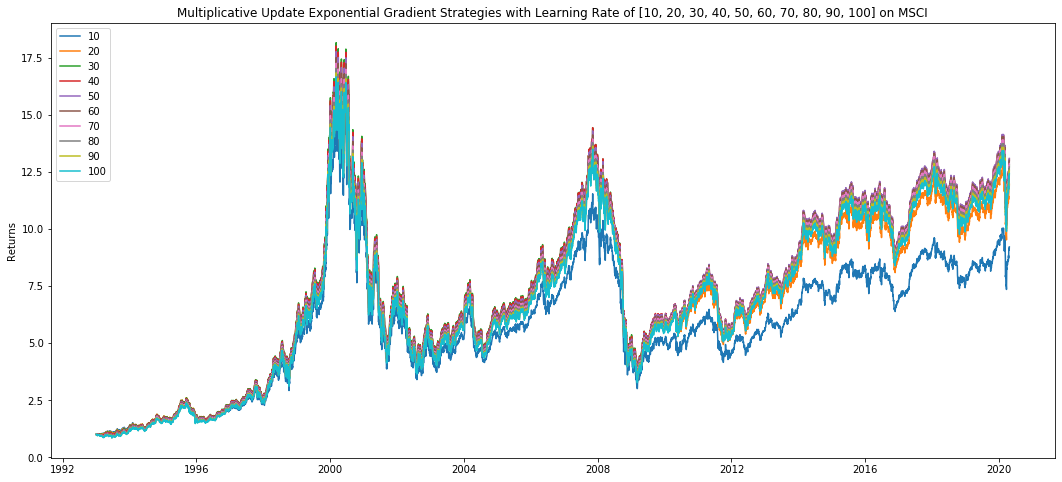

In [17]:
plt.figure(figsize=(18,8));
eta_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for e in eta_values:
    strat = ExponentialGradient(update_rule='MU',eta=e)
    strat.allocate(msci)
    plt.plot(strat.portfolio_return, label = str(e));
plt.title('Multiplicative Update Exponential Gradient Strategies with Learning Rate of [10, 20, 30, 40, 50, 60, 70, 80, 90, 100] on MSCI')
plt.ylabel('Returns')
plt.legend();

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |█████████████████████████████████████████████████-| 97.0% Complete

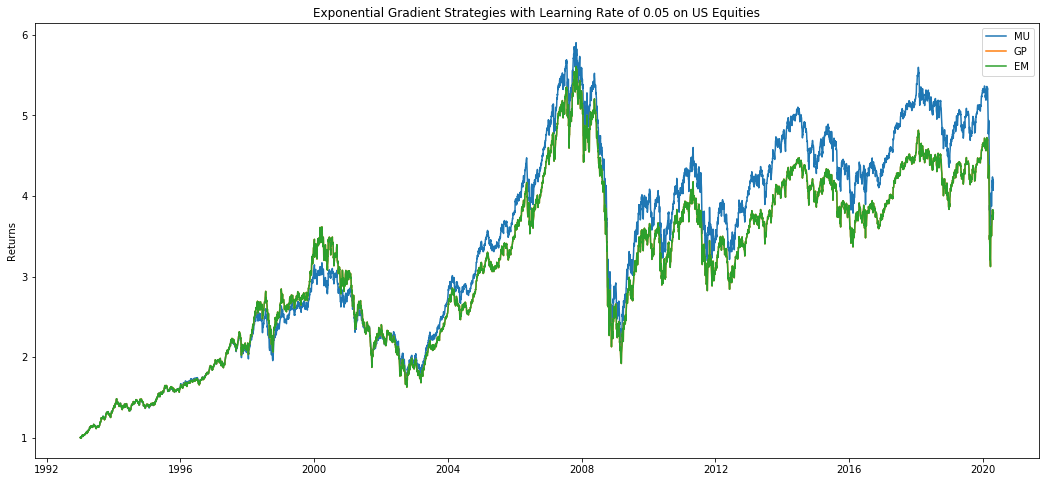

In [18]:
equity_mu_005 = ExponentialGradient(update_rule='MU')
equity_gp_005 = ExponentialGradient(update_rule='GP')
equity_em_005 = ExponentialGradient(update_rule='GP')
equity_mu_005.allocate(msci)
equity_gp_005.allocate(msci)
equity_em_005.allocate(msci)
plt.figure(figsize=(18,8));
plt.plot(equity_mu_005.portfolio_return, label = 'MU');
plt.plot(equity_gp_005.portfolio_return, label = 'GP');
plt.plot(equity_em_005.portfolio_return, label = 'EM');
plt.title('Exponential Gradient Strategies with Learning Rate of 0.05 on US Equities')
plt.ylabel('Returns')
plt.legend();

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |█████████████████████████████████████████████-----| 90.8% Complete

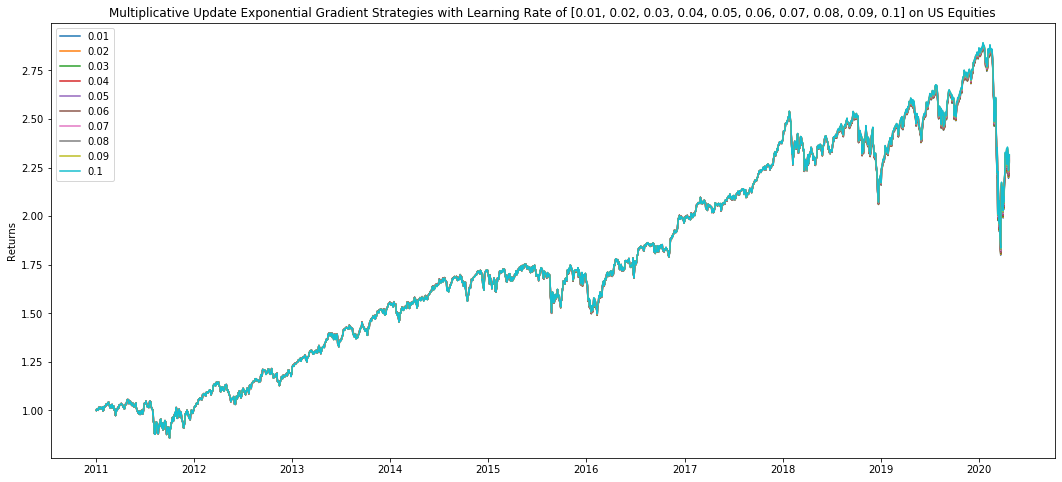

In [19]:
plt.figure(figsize=(18,8));
eta_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
for e in eta_values:
    strat = ExponentialGradient(update_rule='MU',eta=e)
    strat.allocate(equity)
    plt.plot(strat.portfolio_return, label = str(e));
plt.title('Multiplicative Update Exponential Gradient Strategies with Learning Rate of [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1] on US Equities')
plt.ylabel('Returns')
plt.legend();

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete


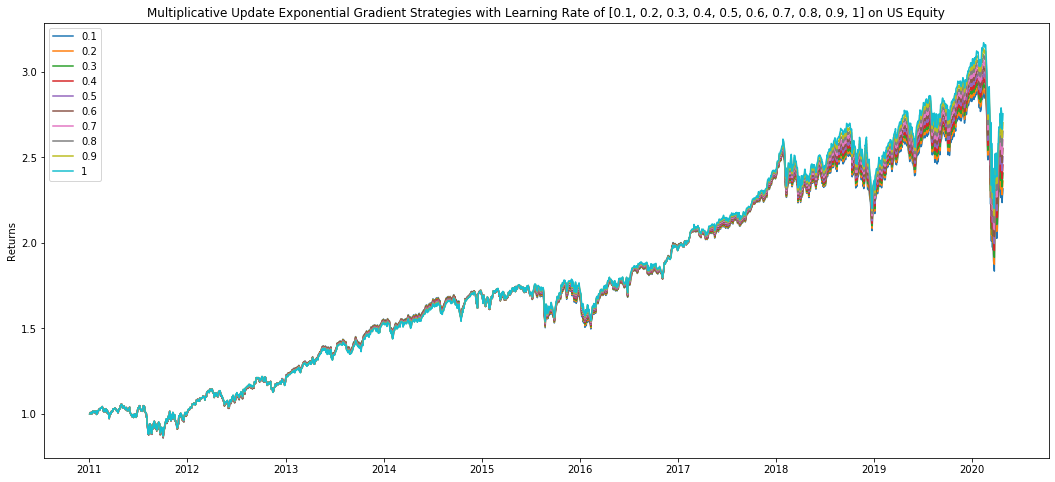

In [21]:
plt.figure(figsize=(18,8));
eta_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
for e in eta_values:
    strat = ExponentialGradient(update_rule='MU',eta=e)
    strat.allocate(equity)
    plt.plot(strat.portfolio_return, label = str(e));
plt.title('Multiplicative Update Exponential Gradient Strategies with Learning Rate of [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1] on US Equity')
plt.ylabel('Returns')
plt.legend();

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete


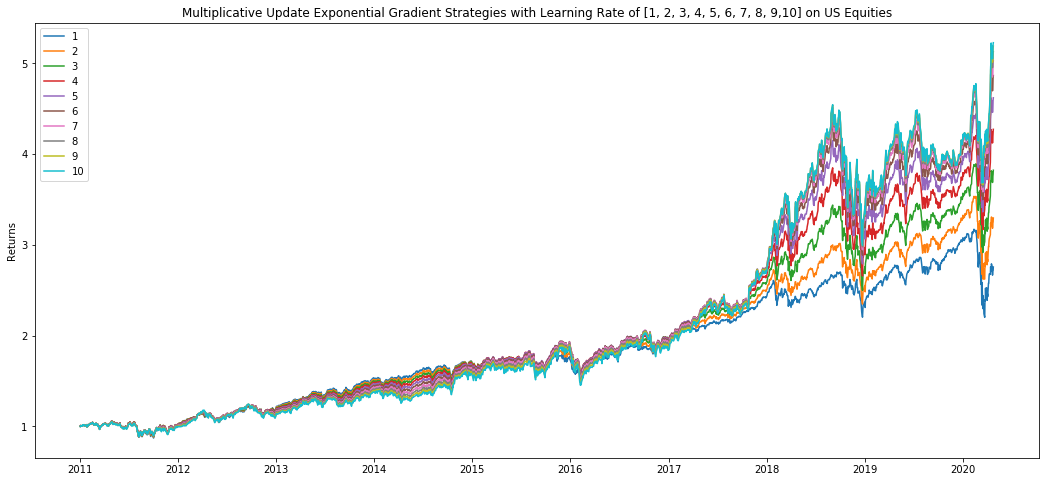

In [22]:
plt.figure(figsize=(18,8));
eta_values = [1, 2, 3, 4, 5, 6, 7, 8, 9,10]
for e in eta_values:
    strat = ExponentialGradient(update_rule='MU',eta=e)
    strat.allocate(equity)
    plt.plot(strat.portfolio_return, label = str(e));
plt.title('Multiplicative Update Exponential Gradient Strategies with Learning Rate of [1, 2, 3, 4, 5, 6, 7, 8, 9,10] on US Equities')
plt.ylabel('Returns')
plt.legend();

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |██████████████████████████████████████████████████| 100.0% Complete
Progress: |█████████████████████████████████████████████-----| 91.0% Complete

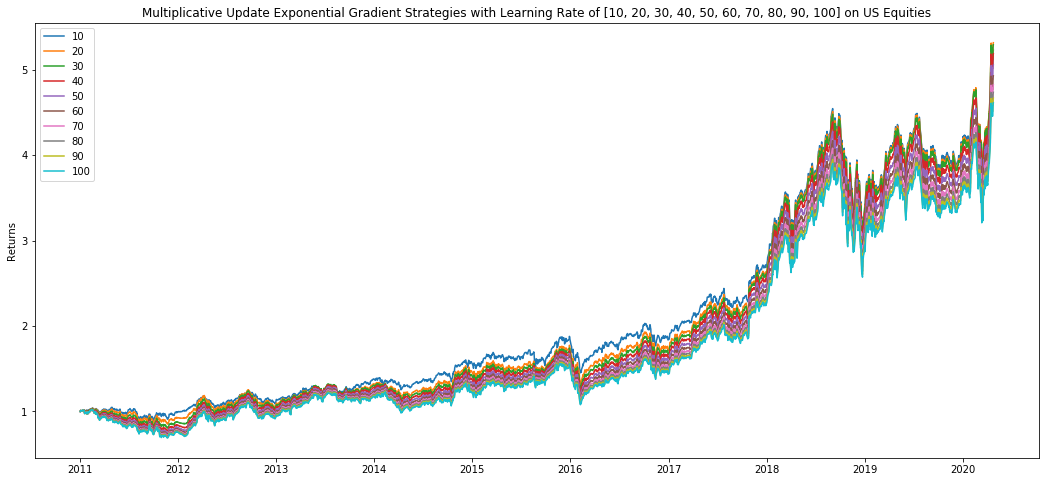

In [23]:
plt.figure(figsize=(18,8));
eta_values = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
for e in eta_values:
    strat = ExponentialGradient(update_rule='MU',eta=e)
    strat.allocate(equity)
    plt.plot(strat.portfolio_return, label = str(e));
plt.title('Multiplicative Update Exponential Gradient Strategies with Learning Rate of [10, 20, 30, 40, 50, 60, 70, 80, 90, 100] on US Equities')
plt.ylabel('Returns')
plt.legend();

In [30]:
strat.portfolio_return.iloc[-1][0]

4.6112801082015125

Yearly rebalancing actually gives a much higher return than the daily ones. This could be explained to the fact that this algorithm now attempts to capture the most value of the asset in the long run instead of looking at short term movements.

## Conclusion

Through this notebook, we were able to explore the basic functionalities of MlFinLab's newest Online Portfolio Selection module. Readers were exposed to a basic introduction to the exponential gradient strategy and will be able to replicate results using the simple methods of the new module.

The next notebook will focus on Momentum strategy called Follow the Leader.

If you enjoyed reading this please remember to leave us a star on GitHub and always let us know how to improve our modules!

:)